In [1]:
import torch
import torch.nn as nn
import torchtext.data as ttd
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re
import unicodedata
from dataset.contractions import CONTRACTION_MAP, expand_contractions
import random
import ast
from others.config import *

spacy = spacy.load('en')
hyperparameters = config['hyperparameters']
gpu = ('cuda:0')

In [2]:
TEXT = ttd.Field(
    sequential=True
    ,batch_first=True
    ,lower=True
    ,tokenize='spacy'
    ,pad_first=True
    )

LABEL = ttd.Field(
    sequential=False
    ,use_vocab=False
    ,is_target=True
    )

In [3]:
dataset = ttd.TabularDataset(
    path='dataset/preprocessed_dataset.csv',
    format='csv',
    skip_header=True,
    fields=[('label', LABEL), ('data', TEXT)]
    )

In [4]:
ex = dataset.examples[0]
print(ex.data)
print(ex.label)

['go', 'jurong', 'point', 'crazi', 'avail', 'bugi', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amor', 'wat']
0


In [5]:
train_dataset, test_dataset = dataset.split(split_ratio=0.7, random_state = random.seed(14))

In [6]:
TEXT.build_vocab(train_dataset)
vocab = TEXT.vocab
print('len vocab: {}'.format(len(vocab)))
# vocab.stoi

len vocab: 5875


In [7]:
train_iter, test_iter = ttd.BucketIterator.splits(
    (train_dataset, test_dataset), 
    sort_key=lambda x: len(x.data),
    batch_sizes=(ast.literal_eval(hyperparameters['batch_sizes'])[0], ast.literal_eval(hyperparameters['batch_sizes'])[1]), 
    device=gpu
    )

In [8]:
for inputs, labels in test_iter:
    print('inputs: {}, shape: {}'.format(inputs, inputs.shape))
    print('lables: {}, shape: {}'.format(labels, labels.shape))
    break

inputs: tensor([[ 926, 1362],
        [   2, 1016],
        [ 210,   77],
        [   0,    5],
        [ 185,   86],
        [2509, 1398],
        [   0,  372],
        [   2,  176],
        [  11,   86],
        [  71,  231],
        [ 126,  227],
        [   0, 1964],
        [ 735, 2389],
        [3599,  225],
        [   0,    0],
        [  84,    0],
        [  11,  323],
        [   0,    0],
        [ 395, 3457],
        [  28,    0],
        [   0,   18],
        [  36,   50],
        [  65,    4],
        [  10,  987],
        [2425, 2384],
        [ 523,  148],
        [ 302,   15],
        [  66,   77],
        [ 304, 3457],
        [  99,  196],
        [ 511,   86],
        [ 317, 1582],
        [   8, 1146],
        [  57,   49],
        [   0,  613],
        [ 391,    0],
        [  55, 2470],
        [ 139, 5251],
        [ 185,  173],
        [ 102,  229],
        [ 791,  279],
        [4441,  419],
        [  17,  195],
        [   5,  202],
        [   4, 1611],
  

In [9]:
class LSTM(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_layers, n_outputs):
        super(LSTM, self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.M = n_hidden
        self.L = n_layers
        self.K = n_outputs
        
        self.embed = nn.Embedding(
            self.V, 
            self.D
            )
        self.lstm = nn.LSTM(
            input_size = self.D,
            hidden_size = self.M,
            num_layers = self.L,
            batch_first = True
            )
        self.fc = nn.Linear(
            self.M, 
            self.K
            )
    
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(gpu)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(gpu)
        
        out = self.embed(X)

        out, _ = self.lstm(out, (h0, c0))

        out, _ = torch.max(out, 1)

        out = self.fc(out)

        return out

In [10]:
checkpoint = torch.load(r'checkpoint\\spam_ham_lowest_val_loss_epoch_6.pth')

In [11]:
model = LSTM(
    len(vocab),
    ast.literal_eval(hyperparameters['embed_dims']), 
    ast.literal_eval(hyperparameters['num_lstm_units']), 
    ast.literal_eval(hyperparameters['num_lstm_layers']), 
    ast.literal_eval(hyperparameters['num_output_classes'])
    ).to(gpu)
model.load_state_dict(checkpoint['state_dict'])
model

LSTM(
  (embed): Embedding(5875, 512)
  (lstm): LSTM(512, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [12]:
test_preds = torch.tensor([])
for inputs, labels in test_iter:
    model.eval()
    with torch.no_grad():
        preds = model(inputs)
        preds = torch.round(torch.sigmoid(preds))
        test_preds = torch.cat(
            (test_preds, preds.cpu())
            )

test_act_labels =  torch.tensor([])
for inputs, labels in test_iter:
    test_act_labels = torch.cat(
            (test_act_labels, labels.cpu())
            )

# print(test_preds)
# print(test_act_labels)

Text(0.5, 17.5, 'Predicted label')

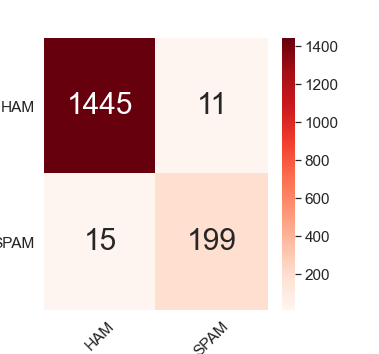

In [13]:
# confusion matrix
cnf_matrix = confusion_matrix(test_act_labels, test_preds)

# plot confusion matrix with seaborn
plt.figure(figsize=(5,5))

x_axis_labels = ['HAM', 'SPAM']
y_axis_labels = ['HAM', 'SPAM']

sns.set(font_scale=1.4)#for label size
sns.heatmap(cnf_matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, annot_kws={"size": 30} , cmap="Reds", fmt='g')

plt.yticks(rotation=360)
plt.xticks(rotation=45)

plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig(r'graphs\cnf_rnn.png', dpi = 100)

In [14]:
report = classification_report(test_act_labels, test_preds)
print(report)

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1456
         1.0       0.95      0.93      0.94       214

    accuracy                           0.98      1670
   macro avg       0.97      0.96      0.96      1670
weighted avg       0.98      0.98      0.98      1670



In [15]:
# text preprocessing
def text_preprocess(doc):
    # remove urls
    url_pattern = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
    no_url = re.sub(url_pattern, '', doc)
    # remove accented characters
    no_accent = unicodedata.normalize('NFKD', no_url).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # expanding contractions
    expanded_contractions = expand_contractions(no_accent)
    # remove special characters (digits included)
    sp_chr_pattern = r'[^a-zA-Z\s]'    
    no_sp_chr = re.sub(sp_chr_pattern, '', expanded_contractions)
    # remove multiple spaces
    single_space = re.sub('\s+',' ', no_sp_chr)
    # lowercasing
    lower = single_space .lower()
    # stopwords removal
    stopword = stopwords.words('english')
    without_stopwords = [y for y in lower.split() if y not in stopword]
    without_stopwords = ' '.join(without_stopwords)
    # stemming
    steme = nltk.porter.PorterStemmer()
    stemed = [steme.stem(y) for y in (without_stopwords.split())]
    stemed = ' '.join(stemed)
    return stemed

In [16]:
# a single prediction
def inference(sentence):
    tokenized = [i.text for i in spacy.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[i] for i in tokenized]
    sample = torch.tensor(indexed).to(gpu)
    sample =  sample.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        predictions = model(sample)
        probability = torch.sigmoid(predictions)
        label = torch.round(probability)
        if label == 1:
            label = 'SPAM'
        else:
            label = 'NOT SPAM'
    return label, probability, indexed

In [17]:
preprocessed = text_preprocess("URGENT! You have won a 1 week FREE membership in our å£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18")
label, probability, indexed = inference(preprocessed)
print('This is a {}\nThe Spam Probability is {:.2f}%'.format(label, probability.item()*100))

This is a SPAM
The Spam Probability is 99.87%


In [18]:
# itos
def i_to_s(indexed):
    itos = [TEXT.vocab.itos[i] for i in indexed]
    itos = ' '.join(itos)
    return(itos)